In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-time-series-20050101-to-20171231/CAT_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UTX_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PFE_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PG_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UNH_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/JNJ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/VZ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/AABA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/BA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/KO_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MCD_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MRK_

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from learntools.time_series.utils import plot_periodogram, seasonal_plot

In [3]:

amzn = pd.read_csv('../input/stock-time-series-20050101-to-20171231/AMZN_2006-01-01_to_2018-01-01.csv',
index_col='Date', parse_dates=['Date'])
amzn.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [4]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [5]:
amzn.reset_index(inplace=True)

In [6]:
# Adding more features to the dataset, in the form day of week, month, and year
amzn['month'] = pd.to_datetime(amzn['Date']).dt.month
amzn['day'] = pd.to_datetime(amzn['Date']).dt.day
amzn['day_name'] = pd.to_datetime(amzn['Date']).dt.day_name()
amzn['year'] = pd.to_datetime(amzn['Date']).dt.year
amzn.head()

,Date,Open,High,Low,Close,Volume,Name,month,day,day_name,year
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,1,3,Tuesday,2006
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,1,4,Wednesday,2006
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,1,5,Thursday,2006
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,1,6,Friday,2006
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,1,9,Monday,2006


In [7]:
amzn.set_index('Date', inplace=True)

In [8]:
amzn.head()

,Open,High,Low,Close,Volume,Name,month,day,day_name,year
Date,,,,,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,1,3,Tuesday,2006
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,1,4,Wednesday,2006
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,1,5,Thursday,2006
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,1,6,Friday,2006
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,1,9,Monday,2006


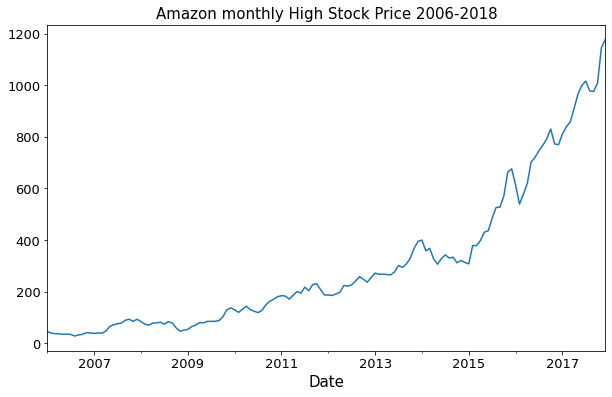

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
amzn['High'].resample('M').mean().plot(fontsize=13)
ax.set_xlabel(xlabel='Date', fontsize=15)
plt.title('Amazon monthly High Stock Price 2006-2018', fontsize=15);

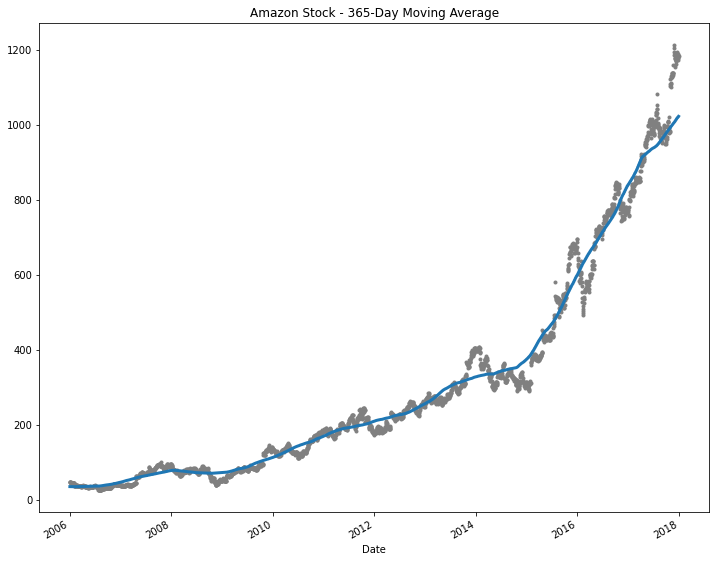

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
trend = amzn['High'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = amzn['High'].plot(style=".", color="0.5")
trend.plot(
    ax=ax, linewidth=3, title="Amazon Stock - 365-Day Moving Average", legend=False,
);

In [11]:
total_days = len(amzn.index)
val_cut = amzn.index[int(0.9 * total_days)+1]
X_train1 = amzn[amzn.index < val_cut]
X_val = amzn[amzn.index >= val_cut]

In [12]:
X_tr_tot_days = len(X_train1.index)
test_cut = X_train1.index[int(0.75 * X_tr_tot_days)+1]
X_train2 = X_train1[X_train1.index < test_cut]
X_test = X_train1[X_train1.index >= test_cut]

In [13]:
X_train2_max = max(X_train2.index)
X_test_min = min(X_test.index)
X_test_max = max(X_test.index)
X_val_min = min(X_val.index)

In [14]:
X_tr = X_train2.drop('Close', axis=1)
X_te = X_test.drop('Close', axis=1)
X_val2 = X_val.drop('Close', axis=1)
y_tr2 = X_train2['Close']
y_te = X_test['Close']
y_val = X_val['Close']

## **Exploring Trend**

In [15]:
dp = DeterministicProcess(
    index=X_tr.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=4,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed,trend**4
Date,,,,,
2006-01-03,1.0,1.0,1.0,1.0,1.0
2006-01-04,1.0,2.0,4.0,8.0,16.0
2006-01-05,1.0,3.0,9.0,27.0,81.0
2006-01-06,1.0,4.0,16.0,64.0,256.0
2006-01-09,1.0,5.0,25.0,125.0,625.0


In [16]:

model = LinearRegression(fit_intercept=False)
model.fit(X, y_tr2)

y_pred = pd.Series(model.predict(X), index=X.index)


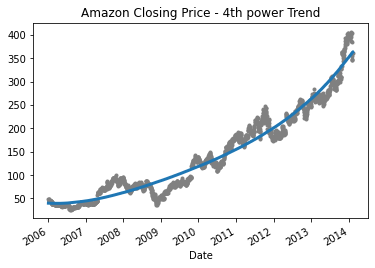

In [17]:
ax = y_tr2.plot(style=".", color="0.5", title="Amazon Closing Price - 4th power Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [18]:
print(f'X_test_length: {len(X_test)}')
print(f'X_val_length: {len(X_val)}')
print(f'X_test_val_length: {len(X_test)+len(X_val)}')

X_test_length: 679
X_val_length: 301
X_test_val_length: 980


In [19]:
X_test_val = pd.concat([X_test, X_val], axis=0)

In [20]:
X_out = dp.out_of_sample(steps=679, forecast_index=X_te.index)

y_fore = pd.Series(model.predict(X_out), index=X_out.index)

y_fore.head()

Date
2014-02-11    363.487115
2014-02-12    363.927137
2014-02-13    364.367808
2014-02-14    364.809129
2014-02-18    365.251100
dtype: float64

In [21]:
# Prediciton for validation set; won't graph these until the end, but predictions are still needed so that the same steps for 
# training and testing data can be followed with validation set
X_out_val = dp.out_of_sample(steps=980, forecast_index=X_test_val.index)

y_fore_val = pd.Series(model.predict(X_out_val), index=X_out_val.index)

y_fore_val.head()

Date
2014-02-11    363.487115
2014-02-12    363.927137
2014-02-13    364.367808
2014-02-14    364.809129
2014-02-18    365.251100
dtype: float64

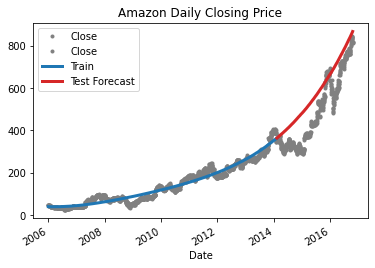

In [22]:
ax = y_tr2.plot(style=".", color="0.5", title="Amazon Daily Closing Price")
ax = y_te.plot(style=".", color="0.5",)
#ax = y_val.plot(style=".", color="0.5")
ax = y_pred.plot(ax=ax, linewidth=3, label="Train")
ax = y_fore.plot(ax=ax, linewidth=3, label="Test Forecast", color="C3")
#ax = y_fore_val.plot(ax=ax, linewidth=3, label="Test + Val Forecast", color="green")
_ = ax.legend()

In [23]:
# Detrending y_tr2 and y_te
y_tr_detrend = y_tr2 - y_pred
y_te_detrend = y_te - y_fore

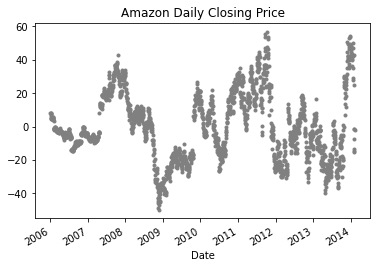

In [24]:
ax = y_tr_detrend.plot(style=".", color="0.5", title="Amazon Daily Closing Price")

## **Exploring Seasonality**

In [25]:
detr_df = pd.concat([pd.DataFrame(y_tr_detrend, columns=['Detrended_Close']), pd.DataFrame(y_te_detrend, columns=['Detrended_Close'])], axis=0)

In [26]:
amzn_tr_te = amzn[amzn.index <= max(detr_df.index)]
amzn_tr_te = pd.concat([amzn_tr_te, detr_df], axis=1)
amzn_tr_te.head()

,Open,High,Low,Close,Volume,Name,month,day,day_name,year,Detrended_Close
Date,,,,,,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,1,3,Tuesday,2006,7.860418
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,1,4,Wednesday,2006,7.547608
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,1,5,Thursday,2006,7.964460
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,1,6,Friday,2006,8.200974
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,1,9,Monday,2006,7.427150


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


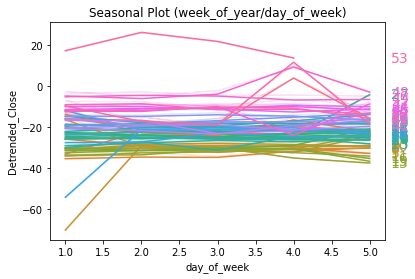

In [27]:
week = {'Sunday': 0, 'Monday': 1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}
amzn_tr_te["week_of_year"] = amzn_tr_te.index.week
amzn_tr_te["day_of_week"] = amzn_tr_te['day_name'].map(week)
seasonal_plot(amzn_tr_te, y='Detrended_Close', period='week_of_year', freq='day_of_week');

In [28]:
detr_df['Detrended_Close'].index

DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2016-10-06', '2016-10-07', '2016-10-10', '2016-10-11',
               '2016-10-12', '2016-10-13', '2016-10-14', '2016-10-17',
               '2016-10-18', '2016-10-19'],
              dtype='datetime64[ns]', name='Date', length=2718, freq=None)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


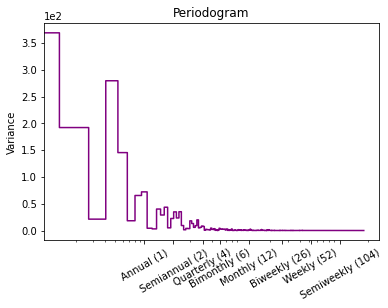

In [29]:
plot_periodogram(detr_df['Detrended_Close']);

The the periodogram seems to drop off after *annual*, (one time a year), or in other words, the frequency strengths of the different coefficients for sin and cosine seem to drop off after annual.

In [30]:
max(detr_df.index)

Timestamp('2016-10-19 00:00:00')

In [31]:
detr_df.index

DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2016-10-06', '2016-10-07', '2016-10-10', '2016-10-11',
               '2016-10-12', '2016-10-13', '2016-10-14', '2016-10-17',
               '2016-10-18', '2016-10-19'],
              dtype='datetime64[ns]', name='Date', length=2718, freq=None)

In [32]:
year_df = amzn_tr_te[['year', 'Detrended_Close']]
year_df.groupby('year').mean()
year_df.reset_index(inplace=True)
year_df

,Date,year,Detrended_Close
0,2006-01-03,2006,7.860418
1,2006-01-04,2006,7.547608
2,2006-01-05,2006,7.964460
3,2006-01-06,2006,8.200974
4,2006-01-09,2006,7.427150
...,...,...,...
2713,2016-10-13,2016,-32.607014
2714,2016-10-14,2016,-40.058339
2715,2016-10-17,2016,-51.201127
2716,2016-10-18,2016,-47.635378


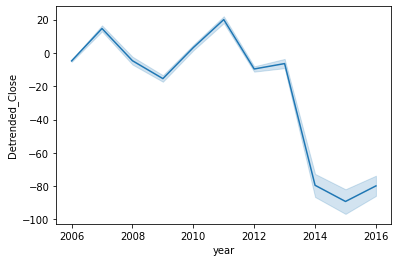

In [33]:
sns.lineplot(data=year_df, x='year', y='Detrended_Close');

It looks like there is some seasonality that occurs every two years, with the peak on the odd numbered years.

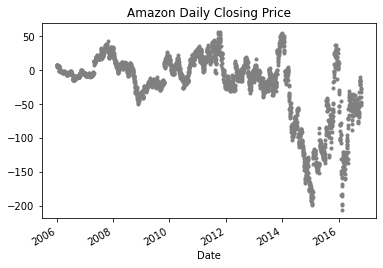

In [34]:
ax = amzn_tr_te['Detrended_Close'].plot(style=".", color="0.5", title="Amazon Daily Closing Price")

In [35]:
print(f'X_train2_max, {X_train2_max}')
print(f'X_test_min, {X_test_min}')
print(f'X_test_max, {X_test_max}')
print(f'X_val_min, {X_val_min}')

X_train2_max, 2014-02-10 00:00:00
X_test_min, 2014-02-11 00:00:00
X_test_max, 2016-10-19 00:00:00
X_val_min, 2016-10-20 00:00:00


In [36]:
X_train = amzn_tr_te[amzn_tr_te.index <= X_train2_max]
X_test = amzn_tr_te[amzn_tr_te.index > X_train2_max]

In [37]:
X_train

,Open,High,Low,Close,Volume,Name,month,day,day_name,year,Detrended_Close,week_of_year,day_of_week
Date,,,,,,,,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,1,3,Tuesday,2006,7.860418,1,2
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,1,4,Wednesday,2006,7.547608,1,3
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,1,5,Thursday,2006,7.964460,1,4
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,1,6,Friday,2006,8.200974,1,5
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,1,9,Monday,2006,7.427150,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-04,349.59,354.00,344.02,347.95,4821177,AMZN,2,4,Tuesday,2014,-13.346704,6,2
2014-02-05,346.00,349.37,337.73,346.45,4439010,AMZN,2,5,Wednesday,2014,-15.283496,6,3
2014-02-06,347.40,354.82,347.40,354.59,3340542,AMZN,2,6,Thursday,2014,-7.580932,6,4


In [38]:
y_train = X_train['Detrended_Close']
y_test = X_test['Detrended_Close']

In [39]:
X_train_enc = pd.get_dummies(data = X_train, columns=['year'])
include = [i for i in X_train_enc.columns if i.startswith('year')]
include
X_train_enc = X_train_enc[include]

In [40]:
X_test_enc = pd.get_dummies(data = X_test, columns=['year'])
include = [i for i in X_test_enc.columns if i.startswith('year')]
include
X_test_enc = X_test_enc[include]

In [41]:
# call_four = CalendarFourier("A", 1)
fourier = CalendarFourier(freq="A", order=1)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    period = 9,
    index=y_train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_tr = dp.in_sample() 

In [42]:
X_tr

,const,trend,"s(2,9)","s(3,9)","s(4,9)","s(5,9)","s(6,9)","s(7,9)","s(8,9)","s(9,9)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,,,,,,,,,,
2006-01-03,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034422,0.999407
2006-01-04,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051620,0.998667
2006-01-05,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068802,0.997630
2006-01-06,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.085965,0.996298
2006-01-09,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.137279,0.990532
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-04,1.0,2035.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552435,0.833556
2014-02-05,1.0,2036.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.566702,0.823923
2014-02-06,1.0,2037.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.580800,0.814046


In [43]:
y_test.index

DatetimeIndex(['2014-02-11', '2014-02-12', '2014-02-13', '2014-02-14',
               '2014-02-18', '2014-02-19', '2014-02-20', '2014-02-21',
               '2014-02-24', '2014-02-25',
               ...
               '2016-10-06', '2016-10-07', '2016-10-10', '2016-10-11',
               '2016-10-12', '2016-10-13', '2016-10-14', '2016-10-17',
               '2016-10-18', '2016-10-19'],
              dtype='datetime64[ns]', name='Date', length=679, freq=None)

In [44]:
lr = LinearRegression()
_ = lr.fit(X_tr, y_train)

y_pred = pd.Series(lr.predict(X_tr), index=y_train.index)
X_te_for = dp.out_of_sample(steps=679, forecast_index=y_test.index)
y_te_for = pd.Series(lr.predict(X_te_for), index= y_test.index)

In [45]:
X_te_for

,const,trend,"s(2,9)","s(3,9)","s(4,9)","s(5,9)","s(6,9)","s(7,9)","s(8,9)","s(9,9)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,,,,,,,,,,
2014-02-11,1.0,2040.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.648630,0.761104
2014-02-12,1.0,2041.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.661635,0.749826
2014-02-13,1.0,2042.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.674444,0.738326
2014-02-14,1.0,2043.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.687053,0.726608
2014-02-18,1.0,2044.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.735417,0.677615
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-13,1.0,2714.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.980575,0.196143
2016-10-14,1.0,2715.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.977064,0.212947
2016-10-17,1.0,2716.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.964806,0.262962


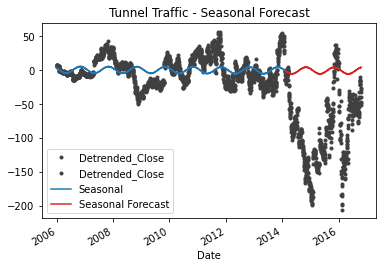

In [46]:
ax = y_train.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_test.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_te_for.plot(ax=ax, label="Seasonal Forecast", color='C3')
#ax = y_pred.plot(ax=ax, label="Seasonal")
_ = ax.legend()

In [47]:
y_te_for.index

DatetimeIndex(['2014-02-11', '2014-02-12', '2014-02-13', '2014-02-14',
               '2014-02-18', '2014-02-19', '2014-02-20', '2014-02-21',
               '2014-02-24', '2014-02-25',
               ...
               '2016-10-06', '2016-10-07', '2016-10-10', '2016-10-11',
               '2016-10-12', '2016-10-13', '2016-10-14', '2016-10-17',
               '2016-10-18', '2016-10-19'],
              dtype='datetime64[ns]', name='Date', length=679, freq=None)